In [113]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
def get_monkey_model():
    # loading model
    model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9'

    model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval()

    # model specifics for optimization
    data_key = '3631807112901'

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 41, 41
    
    return model, n_units, w, h, data_key, dataloaders

model, n_units, w, h, data_key, dataloaders = get_monkey_model()

In [115]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 10)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 10)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 10)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [116]:
start_time = time.time()

best_params_list = []
values_list = []

for unit in range(0, n_units):
    best_params, values = gabor_set.find_optimal_stimulus(model=model, data_key=data_key, unit_idx=unit, total_trials=100)
    best_params_list.append(best_params)
    values_list.append(values)

print("--- %s seconds ---" % (time.time() - start_time))

[INFO 11-25 12:40:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_width. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-25 12:40:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter location_height. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-25 12:40:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-25 12:40:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter spatial_frequency. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool'

--- 979.1854631900787 seconds ---


In [124]:
def get_responses(model, data_key, best_params_list, gabor_set, n_units):
    for unit in range(n_units):
        best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
        image = torch.tensor(best_gabor_img).expand(1, 1, h, w).float()

        response = model(image, data_key=data_key).detach().numpy().squeeze()

        yield response

responses = np.array(list(get_responses(model, data_key, best_params_list, gabor_set, 10)))

In [129]:
def get_random_responses(model, data_key, unit):
    images = np.random.randn(1000, 1, h, w)
    images = torch.tensor(images).float()

    output = model(images, data_key=data_key).detach().numpy().squeeze()

    return np.mean(output[:, unit]), np.std(output[:, unit])

unit = 1
rnd_mean, rnd_std = get_random_responses(model, data_key, unit)

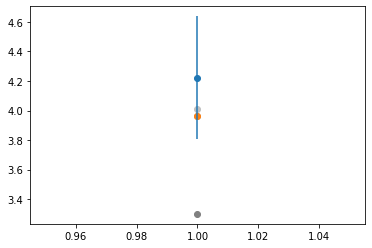

In [130]:
gabor_idx_desc = np.array(responses).argsort(0)[::-1].T

res_opt = np.array(responses)[unit, unit]
res_0 = np.array(responses)[gabor_idx_desc[unit, 0], unit]
res_1 = np.array(responses)[gabor_idx_desc[unit, 1], unit]
res_2 = np.array(responses)[gabor_idx_desc[unit, 2], unit]

plt.figure()

plt.errorbar([unit], [rnd_mean], yerr=[rnd_std], fmt='o', c='tab:blue', label='random response')
plt.scatter([unit], [res_0], c='silver', label='1')
plt.scatter([unit], [res_1], c='#aaa', label='2')
plt.scatter([unit], [res_2], c='gray', label='3')
plt.scatter([unit], [res_opt], c='tab:orange', label='optimal')

plt.show()

In [138]:
from nnvision.utility.measures import get_correlations
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=True)

In [140]:
print(test_correlation[data_key])

[0.32459927 0.47049144 0.60983783 0.31258616 0.16838893 0.7832516
 0.37078443 0.2634063  0.2911932  0.32377008 0.78496367 0.5618
 0.10787632 0.3082543  0.5122549  0.13123666 0.5526203  0.24489652
 0.3374303  0.610806   0.24319884 0.56743526 0.22820996 0.5724795
 0.6535133  0.4250901  0.34454283 0.70903087 0.2239243 ]


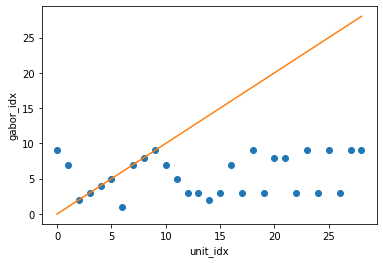

In [144]:
plt.scatter(np.arange(29), np.array(responses).argmax(0)[:29])
plt.plot(np.arange(29), np.arange(29), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.savefig('imgs/gab_vs_unit_monkey_bayesian.png', dpi=300)
plt.show()